# Лабораторная работа №2 (семестр 8)

In [432]:
import numpy as np 
import pandas as pd 
import re

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier

from keras.utils import to_categorical

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D,Flatten,Dropout, Input, Rescaling, RandomRotation, RandomFlip, RandomZoom
from keras.optimizers import RMSprop

## Подготовка данных

In [433]:
df = pd.read_csv('TMNIST_Data.csv')

In [434]:
all_ = list(df['labels'].unique())

pattern_uc = re.compile(r"[A-Z]")
pattern_lc = re.compile(r"[a-z]")
pattern_numbers = re.compile(r"[0-9]")
pattern_symbols = re.compile(r"[\W]|[\_\,]")

lower_case = pattern_lc.findall(str(all_))
Upper_case = pattern_uc.findall(str(all_))
Numbers_ = pattern_numbers.findall(str(all_))
Symbols_ = list(set(pattern_symbols.findall(str(all_))))

group = 1
for list_ in (lower_case,Upper_case,Numbers_,Symbols_):
    df.loc[df['labels'].isin(list_), 'group'] = str(group)
    group += 1

In [435]:
X = df.iloc[:, 2:-1].astype('float32') 
y  = df[['labels']] 

In [436]:
labels = y['labels'].unique()
values = [num for num in range(len(df['labels'].unique()))]
label_dict= dict(zip(labels,values)) 
label_dict_inv = dict(zip(values,labels))
print(label_dict)

{2: 0, 8: 1, 4: 2, 3: 3, 1: 4, 6: 5, 5: 6, 9: 7, 7: 8, 0: 9}


In [437]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Length, Height = 28,28
NCl = y_train.nunique()[0] 

X_train = np.reshape(X_train.values, (X_train.shape[0] ,Length, Height)) 
X_test = np.reshape(X_test.values, (X_test.shape[0] ,Length, Height))

y_train = to_categorical(y_train, NCl, dtype='int' )
y_test = to_categorical(y_test, NCl, dtype='int' )

print(f'X:Train, Test data shape:{X_train.shape},{X_test.shape}')
print(f'Y:Train, Test data shape:{y_train.shape},{y_test.shape}')

X:Train, Test data shape:(23920, 28, 28),(5980, 28, 28)
Y:Train, Test data shape:(23920, 10),(5980, 10)


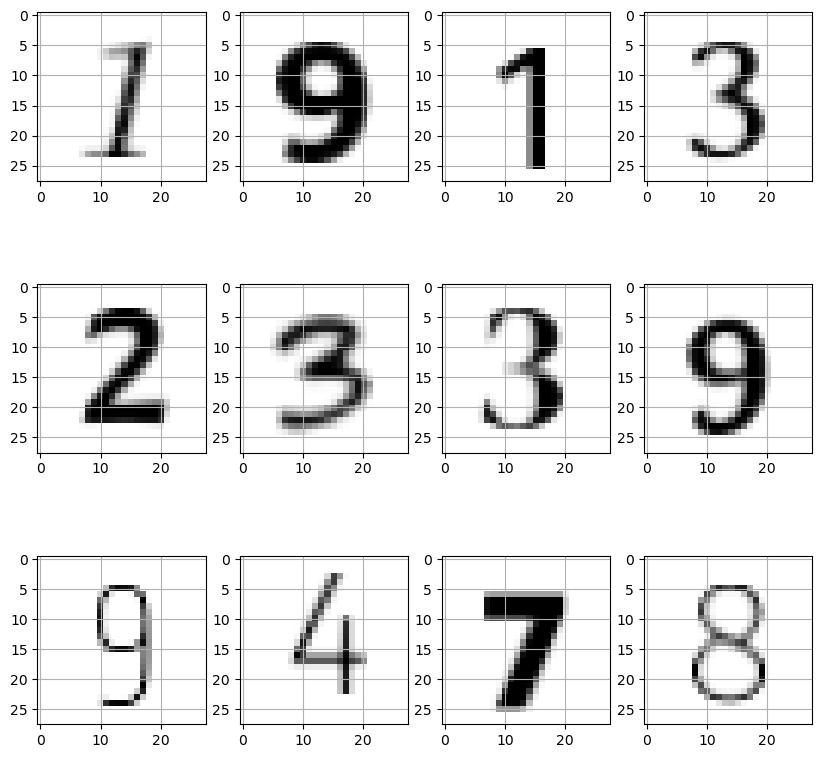

In [438]:
random = shuffle(X_train[:500]) 
fig,ax = plt.subplots(3,4 , figsize = (10,10)) 
axes = ax.flatten()
for i in range(12):
    img = np.reshape(random[i], (28,28)) 
    axes[i].imshow(img, cmap="Greys")
    img_final =np.reshape(img, (1,28,28,1))
    axes[i].grid()

## Модель Random Forest

In [439]:
rf_model = RandomForestClassifier(n_estimators=40, random_state=42)
rf_model.fit(X_train.reshape(-1, 28*28), y_train)

rf_val_accuracy = rf_model.score(X_test.reshape(-1, 28*28), y_test)
print('Random Forest accuracy:', rf_val_accuracy)

Random Forest accuracy: 0.9384615384615385


Всего ошибочно распознанных:  339
Примеры ошибочно распознанных символов для модели RF:


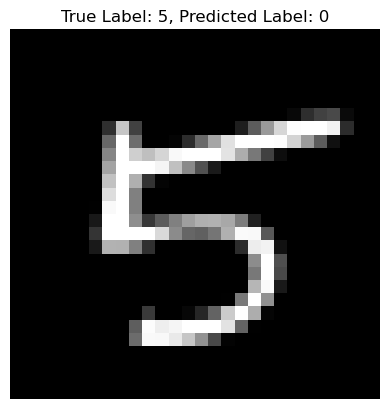

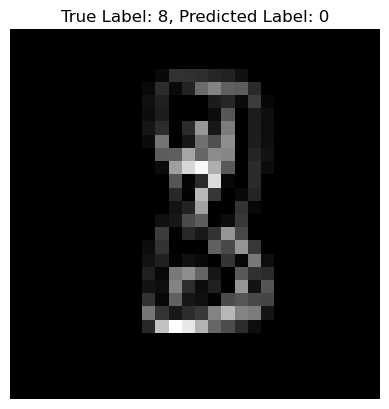

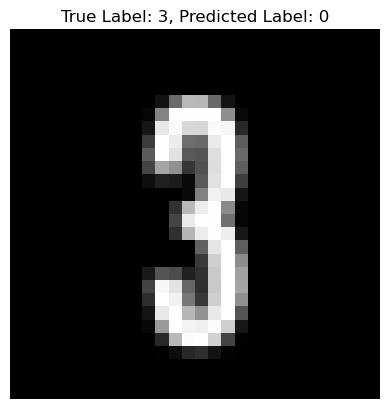

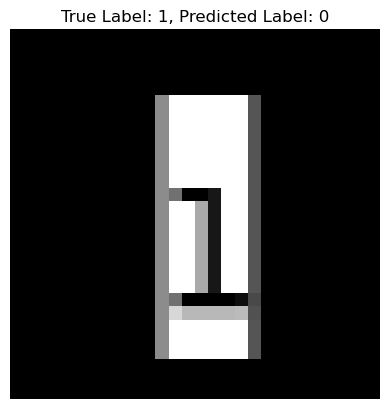

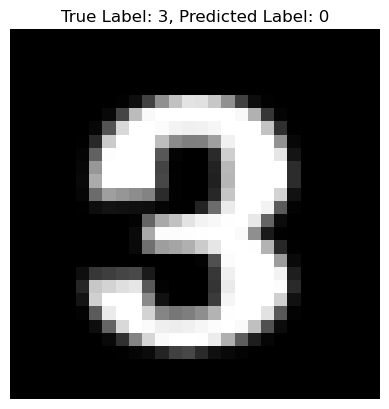

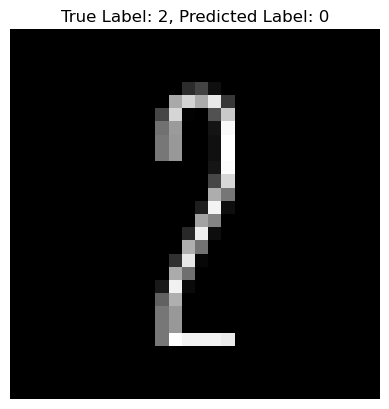

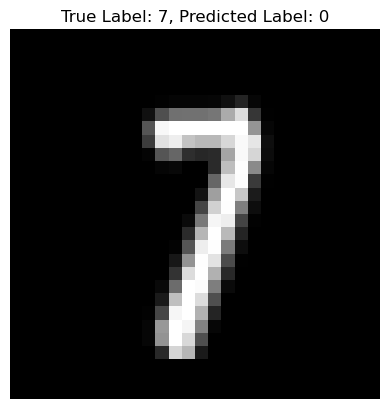

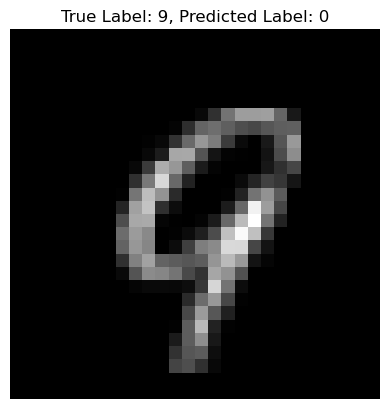

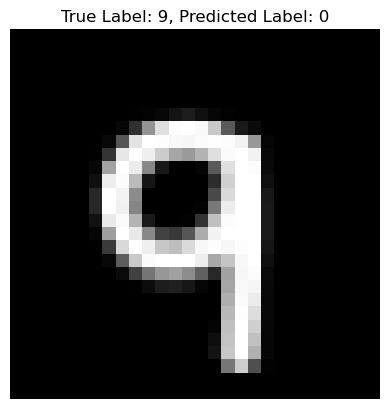

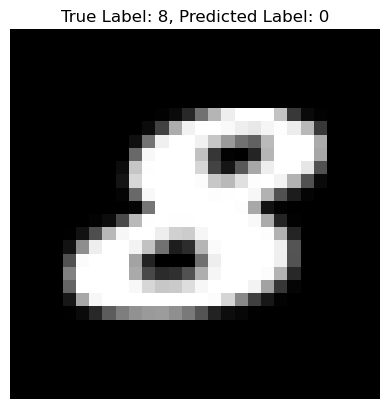

In [440]:
rf_val_predictions = rf_model.predict(X_test.reshape(-1, 28*28))
incorrect_cnn_indices = []
for i in range(len(y_test)):
  max_id = -1
  mx = -1
  for j in range(10):
    if rf_val_predictions[i][j] > mx:
      max_id = j
      mx = rf_val_predictions[i][j]
  max_id_2 = -1
  for j in range(10):
    if y_test[i][j] == 1:
      max_id_2 = j
  if max_id != max_id_2:
    incorrect_cnn_indices.append(i)

print("Всего ошибочно распознанных: ", len(incorrect_cnn_indices))
print("Примеры ошибочно распознанных символов для модели RF:")
for idx in incorrect_cnn_indices[:10]:
		plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
		plt.title(f"True Label: {np.argmax(y_test[idx])}, Predicted Label: {np.argmax(rf_val_predictions[idx])}")
		plt.axis('off')
		plt.show()

## Многослойный перцептрон (с полносвязными слоями)

In [441]:
mlp_model = Sequential()

mlp_model.add(Flatten(input_shape=(28, 28, 1)))
mlp_model.add(Dense(units=64, activation='sigmoid'))
mlp_model.add(Dense(units=64, activation='sigmoid'))
mlp_model.add(Dense(units=10, activation='softmax'))

mlp_model.compile(loss = 'binary_crossentropy', optimizer='RMSprop', metrics = ['acc'])

mlp_history = mlp_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
748/748 [==============================] - 1s 1ms/step - loss: 0.1479 - acc: 0.8313 - val_loss: 0.0494 - val_acc: 0.9410
Epoch 2/10
748/748 [==============================] - 1s 1ms/step - loss: 0.0371 - acc: 0.9484 - val_loss: 0.0320 - val_acc: 0.9532
Epoch 3/10
748/748 [==============================] - 1s 1ms/step - loss: 0.0276 - acc: 0.9576 - val_loss: 0.0265 - val_acc: 0.9592
Epoch 4/10
748/748 [==============================] - 1s 1ms/step - loss: 0.0244 - acc: 0.9617 - val_loss: 0.0241 - val_acc: 0.9632
Epoch 5/10
748/748 [==============================] - 1s 1ms/step - loss: 0.0226 - acc: 0.9645 - val_loss: 0.0220 - val_acc: 0.9677
Epoch 6/10
748/748 [==============================] - 1s 1ms/step - loss: 0.0211 - acc: 0.9663 - val_loss: 0.0228 - val_acc: 0.9647
Epoch 7/10
748/748 [==============================] - 1s 1ms/step - loss: 0.0199 - acc: 0.9683 - val_loss: 0.0215 - val_acc: 0.9664
Epoch 8/10
748/748 [==============================] - 1s 1ms/step - loss: 0.

In [442]:
score = mlp_model.evaluate(X_test, y_test, verbose = 0)
print(f"MLP Validation Accuracy: {round(score[1],4)*100}%")

MLP Validation Accuracy: 96.71%


187/187 [==============================] - 0s 662us/step
Всего ошибочно распознанных:  197
Примеры ошибочно распознанных символов для модели MLP:


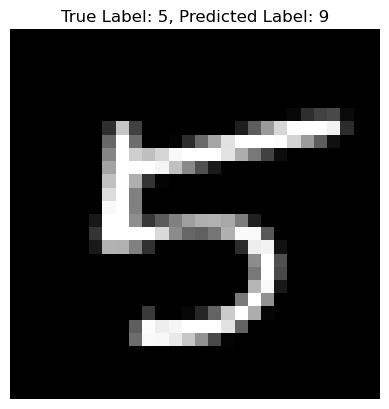

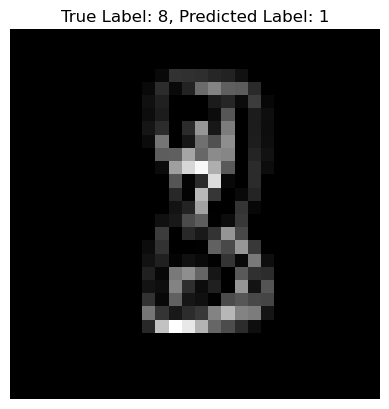

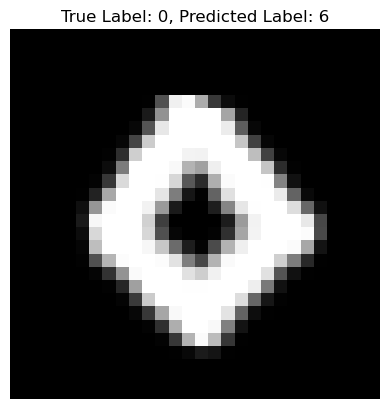

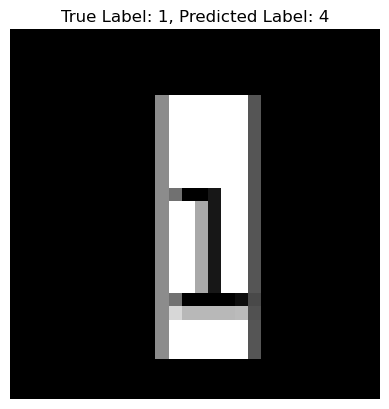

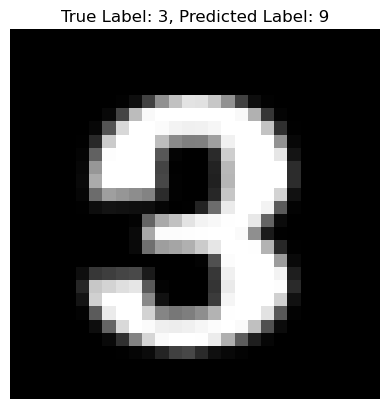

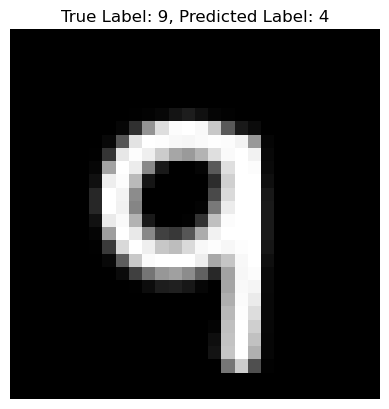

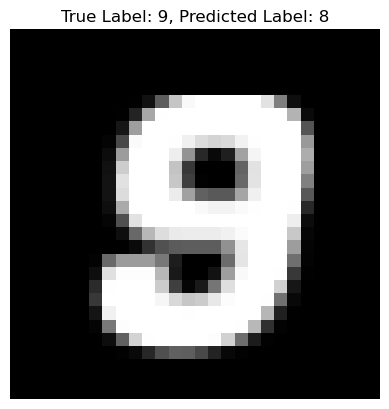

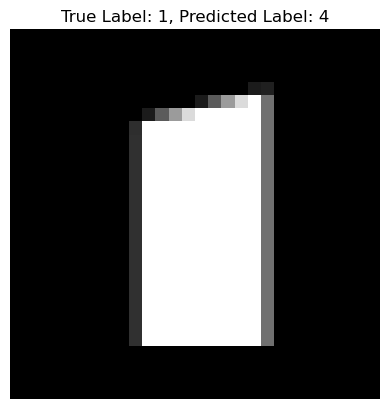

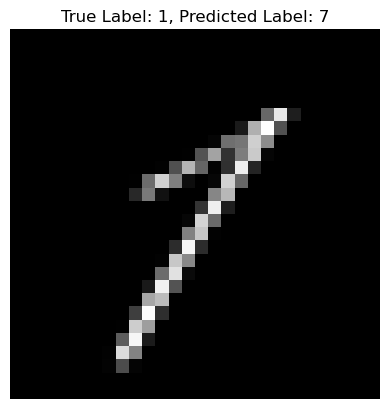

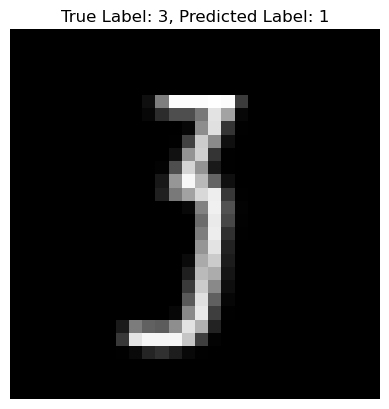

In [443]:
mlp_val_predictions = mlp_model.predict(X_test)
incorrect_cnn_indices = []
for i in range(len(y_test)):
  max_id = -1
  mx = -1
  for j in range(10):
    if mlp_val_predictions[i][j] > mx:
      max_id = j
      mx = mlp_val_predictions[i][j]
  max_id_2 = -1
  for j in range(10):
    if y_test[i][j] == 1:
      max_id_2 = j
  if max_id != max_id_2:
    incorrect_cnn_indices.append(i)

print("Всего ошибочно распознанных: ", len(incorrect_cnn_indices))
print("Примеры ошибочно распознанных символов для модели MLP:")
for idx in incorrect_cnn_indices[:10]:
		plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
		plt.title(f"True Label: {np.argmax(y_test[idx])}, Predicted Label: {np.argmax(mlp_val_predictions[idx])}")
		plt.axis('off')
		plt.show()

## Сверточная нейронная сеть на исходных данных

In [444]:
RGB = 1  
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],X_train.shape[2], RGB)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2],RGB)

X_train = X_train/255
X_test = X_test/255
print(f'Train, Test shapes: {X_train.shape},{X_test.shape}')

Train, Test shapes: (23920, 28, 28, 1),(5980, 28, 28, 1)


In [445]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3,3), activation='relu', input_shape = (Length, Height, RGB),))
cnn_model.add(MaxPool2D(pool_size = (2,2)))

cnn_model.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPool2D(pool_size = (2,2)))

cnn_model.add(Conv2D(128, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPool2D(pool_size = (2,2)))

cnn_model.add(Conv2D(256, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPool2D(pool_size = (2,2)))

cnn_model.add(Dropout(0.5))
cnn_model.add(Flatten())
cnn_model.add(Dense(350, activation = 'relu'))
cnn_model.add(Dense(10, activation = 'sigmoid'))

In [446]:
cnn_model.compile(loss = 'binary_crossentropy', optimizer='RMSprop', metrics = ['acc'])

In [447]:
history = cnn_model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10)

Epoch 1/10
748/748 [==============================] - 10s 13ms/step - loss: 0.0516 - acc: 0.9001 - val_loss: 0.0079 - val_acc: 0.9875
Epoch 2/10
748/748 [==============================] - 10s 13ms/step - loss: 0.0092 - acc: 0.9861 - val_loss: 0.0058 - val_acc: 0.9913
Epoch 3/10
748/748 [==============================] - 10s 14ms/step - loss: 0.0069 - acc: 0.9893 - val_loss: 0.0054 - val_acc: 0.9918
Epoch 4/10
748/748 [==============================] - 12s 16ms/step - loss: 0.0060 - acc: 0.9912 - val_loss: 0.0075 - val_acc: 0.9920
Epoch 5/10
748/748 [==============================] - 11s 15ms/step - loss: 0.0054 - acc: 0.9925 - val_loss: 0.0077 - val_acc: 0.9896
Epoch 6/10
748/748 [==============================] - 10s 14ms/step - loss: 0.0052 - acc: 0.9936 - val_loss: 0.0054 - val_acc: 0.9925
Epoch 7/10
748/748 [==============================] - 10s 13ms/step - loss: 0.0044 - acc: 0.9944 - val_loss: 0.0060 - val_acc: 0.9930
Epoch 8/10
748/748 [==============================] - 10s 13ms

In [448]:
score = cnn_model.evaluate(X_test, y_test, verbose = 0)
print(f"Test Accuracy:{round(score[1],4)*100}%")

Test Accuracy:99.21%


In [449]:
def Plott (data):
    fig, ax = plt.subplots(1,2 , figsize = (20,7))
    ax[0].plot(data.history['acc'])
    ax[0].plot(data.history['val_acc'])
    ax[0].set_title('model accuracy')
    ax[0].legend(['train', 'test'], loc='upper left')

    ax[1].plot(data.history['loss'], label =['loss'])
    ax[1].plot(data.history['val_loss'] ,label =['val_loss'])
    ax[1].set_title('model loss')
    ax[1].legend(['train', 'test'], loc='upper left')
    plt.show()

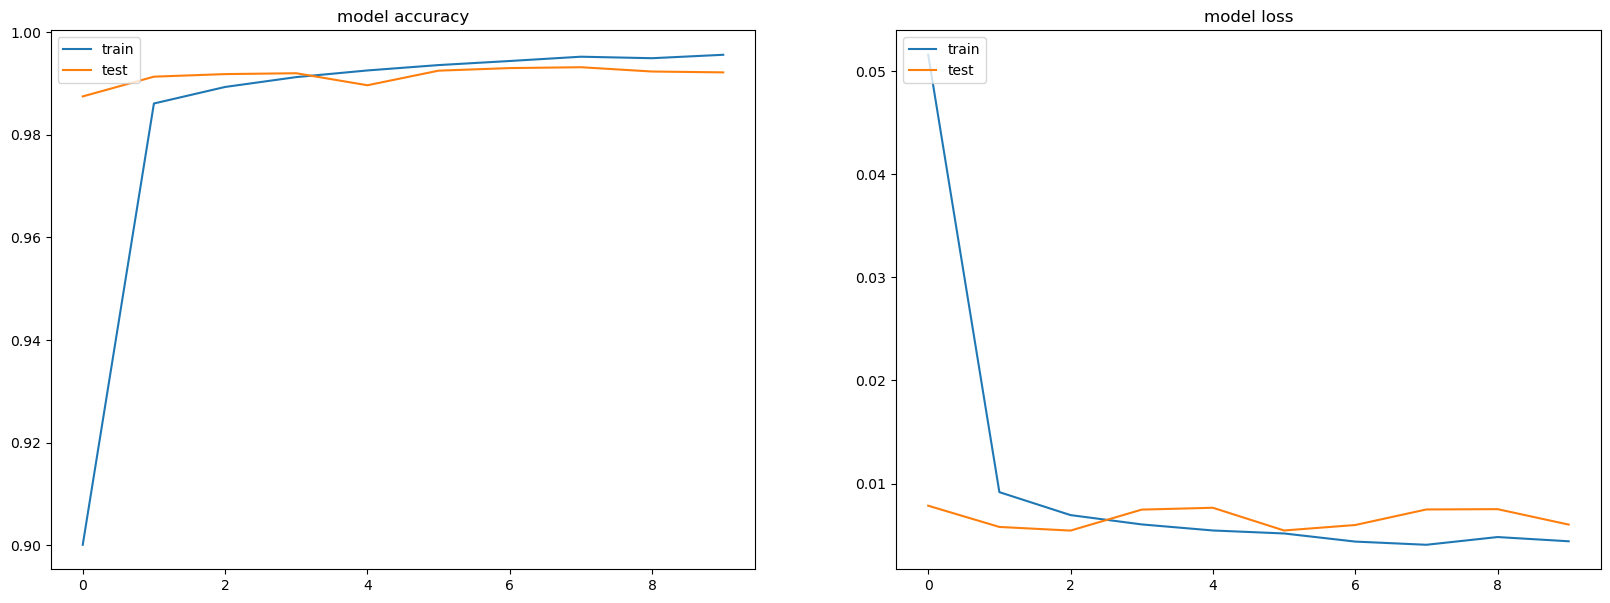

In [450]:
Plott(history)

187/187 [==============================] - 1s 4ms/step
Всего ошибочно распознанных:  47
Примеры ошибочно распознанных символов для модели CNN:


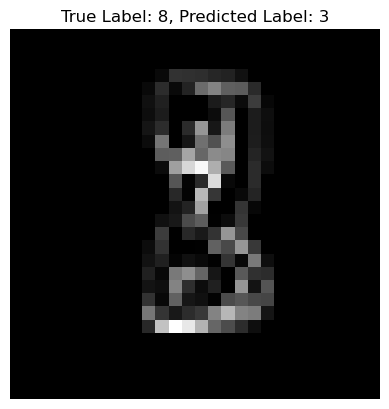

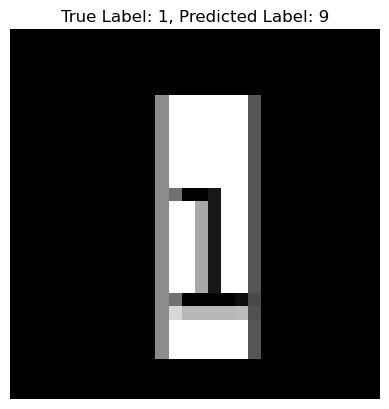

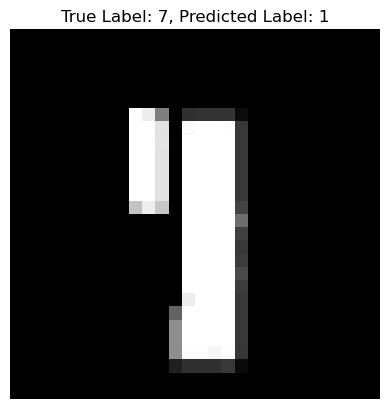

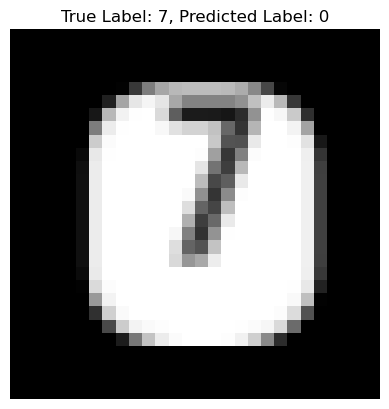

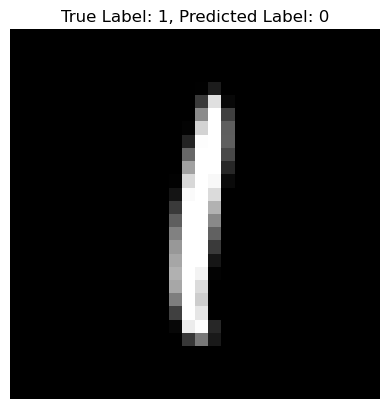

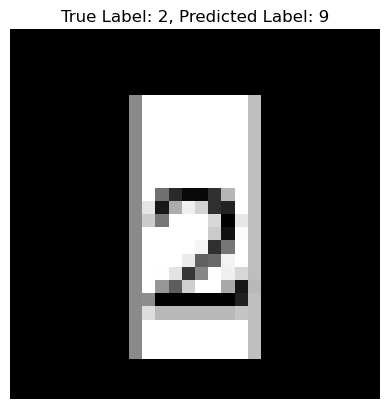

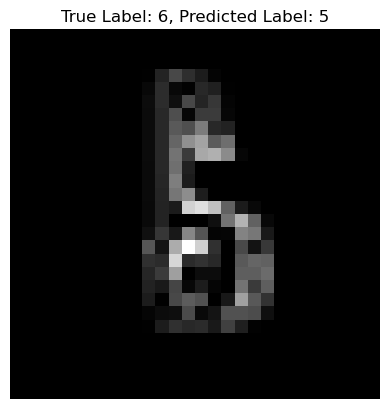

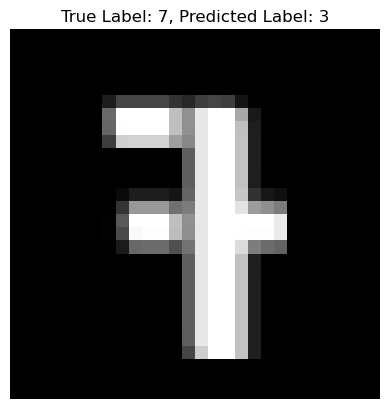

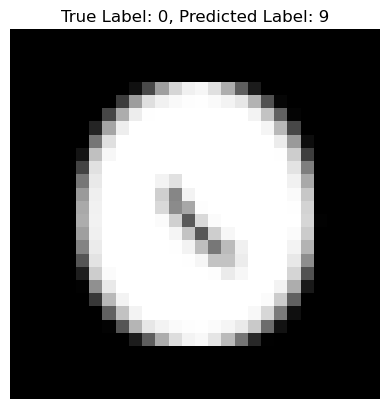

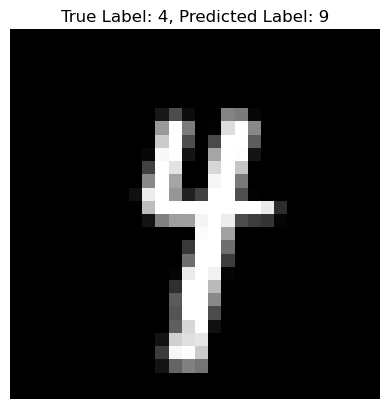

In [451]:
cnn_val_predictions = cnn_model.predict(X_test)
incorrect_cnn_indices = []
for i in range(len(y_test)):
  max_id = -1
  mx = -1
  for j in range(10):
    if cnn_val_predictions[i][j] > mx:
      max_id = j
      mx = cnn_val_predictions[i][j]
  max_id_2 = -1
  for j in range(10):
    if y_test[i][j] == 1:
      max_id_2 = j
  if max_id != max_id_2:
    incorrect_cnn_indices.append(i)

print("Всего ошибочно распознанных: ", len(incorrect_cnn_indices))
print("Примеры ошибочно распознанных символов для модели CNN:")
for idx in incorrect_cnn_indices[:10]:
		plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
		plt.title(f"True Label: {np.argmax(y_test[idx])}, Predicted Label: {np.argmax(cnn_val_predictions[idx])}")
		plt.axis('off')
		plt.show()

## Сверточная нейронная сеть на расширенных данных

In [456]:
model = Sequential ()

model.add(Input(shape= (Length, Height, RGB)))
model.add(Rescaling(scale=1./255))
model.add(RandomRotation(0.1))
# model.add(RandomFlip('horizontal'))
model.add(RandomZoom(0.1))

model.add(Conv2D(32, (3,3), activation='relu', input_shape = (Length, Height, RGB),))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(350, activation = 'relu'))
model.add(Dense(10, activation = 'sigmoid'))

In [459]:
model.compile(loss = 'categorical_crossentropy', optimizer='RMSprop', metrics = ['acc'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10)

Epoch 1/10
748/748 [==============================] - 12s 15ms/step - loss: 2.3048 - acc: 0.0982 - val_loss: 2.3033 - val_acc: 0.1017
Epoch 2/10
748/748 [==============================] - 12s 16ms/step - loss: 2.3042 - acc: 0.0966 - val_loss: 2.3061 - val_acc: 0.0943
Epoch 3/10
748/748 [==============================] - 12s 16ms/step - loss: 2.3033 - acc: 0.1002 - val_loss: 2.3033 - val_acc: 0.1017
Epoch 4/10
748/748 [==============================] - 12s 16ms/step - loss: 2.3034 - acc: 0.1006 - val_loss: 2.3033 - val_acc: 0.1002
Epoch 5/10
748/748 [==============================] - 11s 15ms/step - loss: 2.3032 - acc: 0.1020 - val_loss: 2.3028 - val_acc: 0.1002
Epoch 6/10
748/748 [==============================] - 13s 17ms/step - loss: 2.3030 - acc: 0.0987 - val_loss: 2.3033 - val_acc: 0.0967
Epoch 7/10
748/748 [==============================] - 12s 16ms/step - loss: 2.3029 - acc: 0.0985 - val_loss: 2.3032 - val_acc: 0.0943
Epoch 8/10
748/748 [==============================] - 13s 17ms

Test Accuracy:9.36%


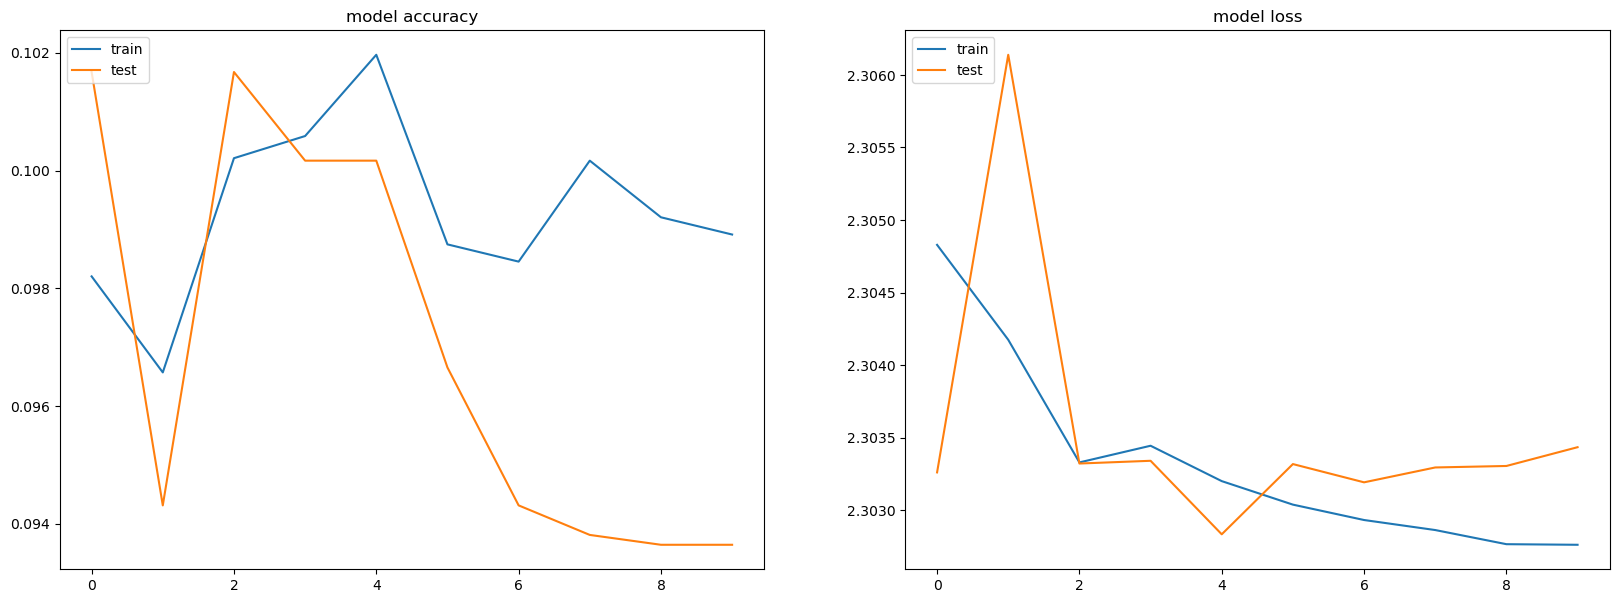

In [460]:
score = model.evaluate(X_test,y_test,verbose = 0)
print(f"Test Accuracy:{round(score[1],4)*100}%")
Plott(history)

187/187 [==============================] - 1s 5ms/step
Всего ошибочно распознанных:  5420
Примеры ошибочно распознанных символов для модели CNN:


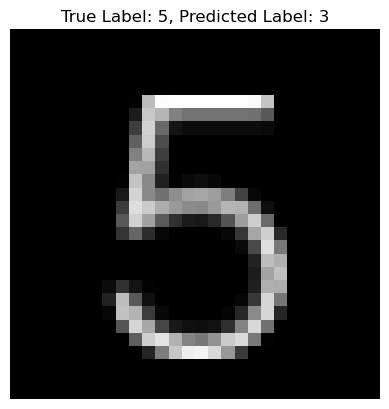

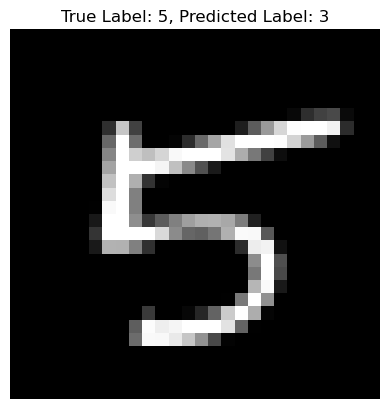

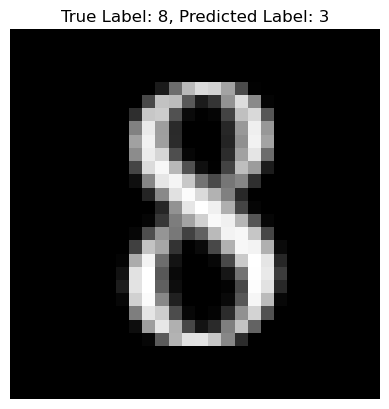

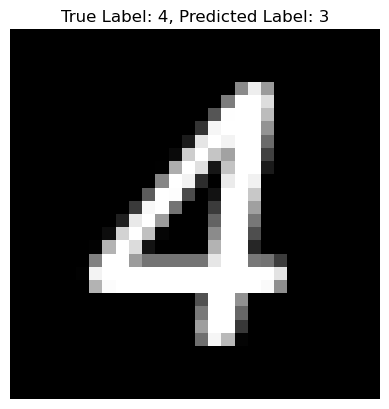

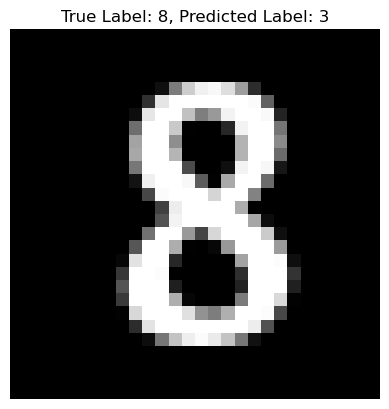

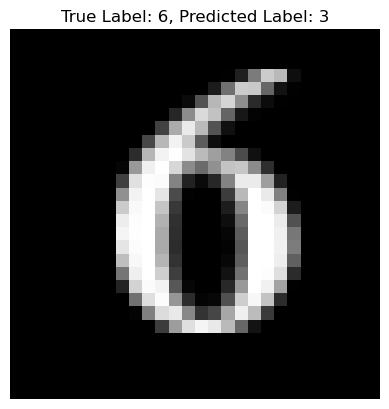

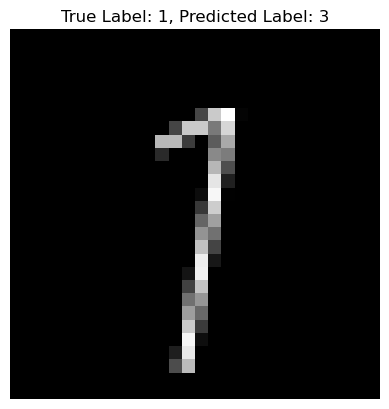

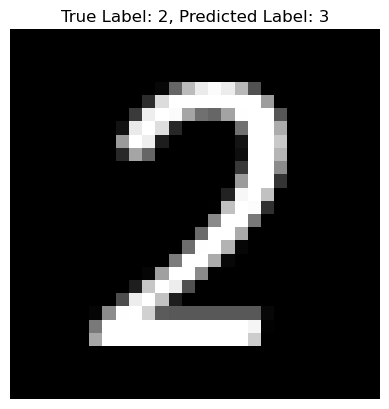

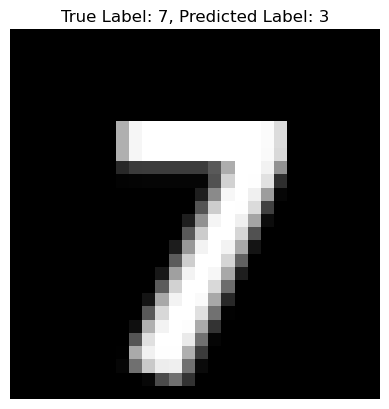

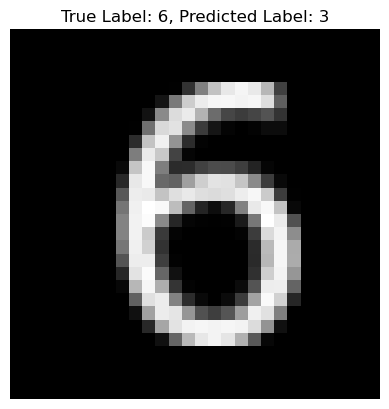

In [461]:
cnn_val_predictions = model.predict(X_test)
incorrect_cnn_indices = []
for i in range(len(y_test)):
  max_id = -1
  mx = -1
  for j in range(10):
    if cnn_val_predictions[i][j] > mx:
      max_id = j
      mx = cnn_val_predictions[i][j]
  max_id_2 = -1
  for j in range(10):
    if y_test[i][j] == 1:
      max_id_2 = j
  if max_id != max_id_2:
    incorrect_cnn_indices.append(i)

print("Всего ошибочно распознанных: ", len(incorrect_cnn_indices))
print("Примеры ошибочно распознанных символов для модели CNN:")
for idx in incorrect_cnn_indices[:10]:
		plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
		plt.title(f"True Label: {np.argmax(y_test[idx])}, Predicted Label: {np.argmax(cnn_val_predictions[idx])}")
		plt.axis('off')
		plt.show()